In [1]:
import argparse
from copy import deepcopy
import logging
import random
from collections import defaultdict
from os.path import join
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from sklearn.model_selection import train_test_split
import joblib
import imodels
import inspect
import os.path
import imodelsx.cache_save_utils
import sys

#path_to_repo = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

#os.chdir(path_to_repo)
#os.chdir('/home/mattyshen/interpretableDistillation')
sys.path.append('..')

import interpretDistill.model
import interpretDistill.data

2024-06-28 11:25:12.037903: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 11:25:13.054015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mattyshen/anaconda3/lib/python3.9/site-packages/botocore/httpsession.py:34: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


In [2]:
class ARGS:
    def __init__(self, a_dict):
        for k in a_dict.keys():
            exec(f'self.{k} = a_dict["{k}"]')
            
def fit_model(model, X_train, y_train, feature_names, no_interaction, r):
    # fit the model
    fit_parameters = inspect.signature(model.fit).parameters.keys()
    if "feature_names" in fit_parameters and feature_names is not None:
        model.fit(X_train, y_train, feature_names=feature_names)
    elif "no_interaction" in fit_parameters and len(no_interaction) > 0:
        #ft_distill models
        model.fit(X_train, y_train, no_interaction=no_interaction)
    elif type(model) == imodels.importance.rf_plus.RandomForestPlusRegressor:
        model.fit(X_train, y_train.to_numpy())
    else:
        model.fit(X_train, y_train)

    return r, model


def evaluate_model(model, comp, task, X_train, X_val, y_train, y_val, r):
    """Evaluate model performance on each split"""
    if task == 'regression':
        metrics = {
            "r2_score": r2_score,
        }
    else:
        metrics = {
            "accuracy": accuracy_score,
        }
    for split_name, (X_, y_) in zip(
        ["train", "val"], [(X_train, y_train), (X_val, y_val)]
    ):
        y_pred_ = model.predict(X_)
        for metric_name, metric_fn in metrics.items():
            r[f"{metric_name}_{split_name}_{comp}"] = metric_fn(y_, y_pred_)

    return r

In [3]:
datasets = ["miami_housing", "qsar", "allstate", "mercedes", "transaction"] #["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", 
                 #"miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
models = ["featurizer", "random_forest", "figs", "xgboost", "resnet", "ft_transformer", "ft_distill", "rf_plus"]

In [4]:
# args_dict = {}
# args_dict['seed'] = 0
# args_dict['model_name'] = 'resnet'
# args_dict['featurizer_name'] = 'featurizer'
# args_dict['distiller_name'] = 'rf_plus'
# args_dict['featurizer_frac'] = 0.3
# args_dict['featurizer_overlap'] = 1
# args_dict['depth'] = 3
# args_dict['bit'] = 1
# args_dict['max_depth'] = 4
# args_dict['max_rules'] = 60
# args_dict['max_trees'] = 30
# args_dict['pre_interaction'] = 'l0l2'
# args_dict['pre_max_features'] = 0.5
# args_dict['post_interaction'] = 'l0l2'
# args_dict['post_max_features'] = 30
# args_dict['n_epochs'] = 100
# args_dict['gpu'] = 0
# args_dict['size_interactions'] = 3

In [5]:
args_dict = {}
args_dict['seed'] = 1
args_dict['model_name'] = 'ft_transformer'
args_dict['featurizer_name'] = 'no_featurizer'
args_dict['featurizer_frac'] = 0.3
args_dict['featurizer_overlap'] = 1
args_dict['depth'] = 3
args_dict['bit'] = 1
args_dict['max_depth'] = 4
args_dict['max_features'] = 1
args_dict['max_trees'] = 20
args_dict['max_rules'] = 50
args_dict['n_epochs'] = 100
args_dict['gpu'] = 0

In [6]:
r_ovr = {}
args_dict['dataset_name'] = datasets[2]
args = ARGS(args_dict)

np.random.seed(args.seed)
random.seed(args.seed)
# torch.manual_seed(args.seed)

X, y, args = interpretDistill.data.load_tabular_dataset(args.dataset_name, args)
X = pd.DataFrame(X.values, columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=args.seed)

# load tabular data
# https://csinva.io/imodels/util/data_util.html#imodels.util.data_util.get_clean_dataset
# X_train, X_test, y_train, y_test, feature_names = imodels.get_clean_dataset('compas_two_year_clean', data_source='imodels', test_size=0.33)

model = interpretDistill.model.get_model(args.task_type, args.model_name, args)
no_interaction = []
# set up saving dictionary + save params file
r = defaultdict(list)
r.update(vars(args))
# imodelsx.cache_save_utils.save_json(
#     args=args, save_dir=save_dir_unique, fname="params.json", r=r
# )

# fit
feature_names = list(X_train.columns)

r, model = fit_model(model, X_train, y_train, feature_names, no_interaction, r)
r = evaluate_model(model, 'true', args.task_type, X_train, X_val, y_train, y_val, r)

# # save results
# print(f'save_dir_unique: {save_dir_unique}')
# joblib.dump(
#     r, join(save_dir_unique, "results.pkl")
# )  # caching requires that this is called results.pkl
# #joblib.dump(model, join(save_dir_unique, "model.pkl"))
# logging.info("Succesfully completed :)\n\n")

r_ovr[dn] = r
    
    

IndexError: index out of range in self

In [ ]:
model.cat_cardinalities

In [ ]:
model.device

In [ ]:
y

In [ ]:
model

In [ ]:
X.todense()

In [ ]:
type(pd.DataFrame(X.values, columns=X.columns, index=X.index))

In [ ]:
type(distiller)

In [ ]:
type(distiller) == imodels.importance.rf_plus.RandomForestPlusRegressor

In [ ]:
params_coupled_dict = {( 
  'dataset_name', 
  'model_name',
  'featurizer_name',
  'featurizer_frac',
  'depth',
  'bit',
  'max_depth',
  'max_rules',
  'max_trees',
  'pre_interaction',
  'pre_max_features',
  'post_interaction',
  'post_max_features'
 ):
 [(dn,
   mn,
   fn,
   ff,
   d,
   b,
   md, 
   mr, 
   mt,
   prei,
   premf,
   posti,
   postmf
  )
 for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
 for mn in ["random_forest", "rf_plus", "xgboost", "resnet", "ft_transformer"]
 for fn in ["no_featurizer", "featurizer"]
 for ff in [0.3, 0.7]
 for d in [2, 3]
 for b in [0, 1]
 for md in [4, 5]
 for mr in [1]
 for mt in [1]
 for prei in ["l0l2"]
 for premf in [0]
 for posti in ["l0l2"]
 for postmf in [0]
 ] + 
 [(dn,
   mn,
   fn,
   ff,
   d,
   b,
   md, 
   mr, 
   mt,
   prei,
   premf,
   posti,
   postmf
  )
 for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
 for mn in ["figs"]
 for fn in ["no_featurizer", "featurizer"]
 for ff in [0.3, 0.7]
 for d in [2, 3]
 for b in [0, 1]
 for md in [1]
 for mr in [50, 60]
 for mt in [30]
 for prei in ["l0l2"]
 for premf in [0]
 for posti in ["l0l2"]
 for postmf in [0]
 ] + 
 [(dn,
   mn,
   fn,
   ff,
   d,
   b,
   md, 
   mr, 
   mt,
   prei,
   premf,
   posti,
   postmf
  )
 for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
 for mn in ["ft_distill"]
 for fn in ["featurizer"]
 for ff in [0.3, 0.7]
 for d in [2, 3]
 for b in [0, 1]
 for md in [1]
 for mr in [1]
 for mt in [1]
 for prei in ["l1l2", "l0l2"]
 for premf in [0.5]
 for posti in ["l0l2"]
 for postmf in [25, 30]
 ]
}

In [ ]:
params_coupled_dict = {}
#RF, RF+ params
params_coupled_dict.update({('dataset_name', 
                             'model_name', 
                             'max_depth', 
                             'max_features'):
                            [(dn, mn, md, mf) 
                             for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
                             for mn in ['random_forest', 'rf_plus']
                             for md in [4, 5, 6]
                             for mf in [0.5, 0.75, 1]
                            ]})
#FIGS params
params_coupled_dict.update({('dataset_name', 
                             'model_name', 
                             'max_rules', 
                             'max_trees',
                             'max_features'):
                            [(dn, mn, mr, mt, mf) 
                             for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
                             for mn in ['figs']
                             for mr in [60]
                             for mt in [20, 30]
                             for mf in [0.5, 0.75, 1]
                            ]})
#XGB params
params_coupled_dict.update({('dataset_name', 
                             'model_name', 
                             'max_depth'):
                            [(dn, mn, md) 
                             for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
                             for mn in ['xgboost']
                             for md in [4, 5, 6]
                            ]})
#FT, ResNet params
params_coupled_dict.update({('dataset_name', 
                             'model_name', 
                             'n_epochs'):
                            [(dn, mn, ne) 
                             for dn in ["ca_housing", "abalone", "parkinsons", "airfoil", "cpu_act", "concrete", "powerplant", "miami_housing", "insurance", "qsar", "allstate", "mercedes", "transaction"]
                             for mn in ['ft_transformer', 'resnet']
                             for ne in [100, 200]
                            ]})

In [ ]:
params_coupled_dict.keys()

In [ ]:
5*sum([len(params_coupled_dict[k]) for k in params_coupled_dict.keys()])

In [ ]:
t.update({('to', 'ho'): [(9, 10), (51, 61)]})

In [ ]:
t

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

# Generating a sample dataset
n_samples = 100
n_features = 5

# Sample DataFrame with n_samples rows and n_features columns
X = pd.DataFrame(np.random.randn(n_samples, n_features), columns=[f'feature_{i}' for i in range(n_features)])
y = pd.Series(np.random.randn(n_samples))

# Initializing KFold
kf = KFold(n_splits=5)

# Iterating over each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # X_in, y_in for training data in current fold
    X_in, y_in = X_train, y_train
    
    # X_out, y_out for test data in current fold
    X_out, y_out = X_test, y_test
    


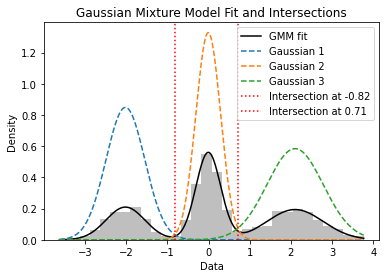

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Generate some sample data
np.random.seed(42)
data = np.concatenate([np.random.normal(loc=-2, scale=0.5, size=300),
                       np.random.normal(loc=0, scale=0.3, size=500),
                       np.random.normal(loc=2, scale=0.7, size=400)])

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=3)
gmm.fit(data.reshape(-1, 1))

# Extract the means and variances of the fitted Gaussians
means = gmm.means_.flatten()
variances = gmm.covariances_.flatten()
std_devs = np.sqrt(variances)

# Sort the means for determining intersections
sorted_indices = np.argsort(means)
sorted_means = means[sorted_indices]
sorted_variances = variances[sorted_indices]


# Determine the intersection points using the provided formula
intersections = []
for i in range(len(sorted_means) - 1):
    mu1, var1 = sorted_means[i], sorted_variances[i]
    mu2, var2 = sorted_means[i + 1], sorted_variances[i + 1]
    
    term1 = mu1*var2 - mu2*var1
    term2 = np.sqrt(var1*var2) * np.sqrt((mu1-mu2)**2 + (var2-var1)*np.log(var2/var1))
    term3 = var2-var1
    #intersections.append((((term1+term2)/term3), ((term1-term2)/term3)))
    intersections.append(((term1+term2)/term3))


# Plot the histogram and the fitted Gaussians
x = np.linspace(min(data), max(data), 1000)
pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))

plt.hist(data, bins=30, density=True, alpha=0.5, color='gray')
plt.plot(x, pdf, label='GMM fit', color='black')

# Plot the individual Gaussians
for i in range(len(means)):
    plt.plot(x, (1/np.sqrt(2 * np.pi * variances[sorted_indices][i])) * 
             np.exp(-(x - sorted_means[i])**2 / (2 * variances[sorted_indices][i])),
             label=f'Gaussian {i+1}', linestyle='--')

# Plot the intersection points
for intersection in intersections:
    plt.axvline(intersection, color='red', linestyle=':', label=f'Intersection at {intersection:.2f}')

plt.legend()
plt.xlabel('Data')
plt.ylabel('Density')
plt.title('Gaussian Mixture Model Fit and Intersections')
plt.show()


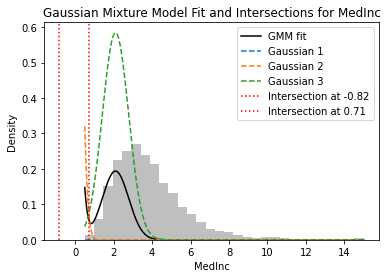

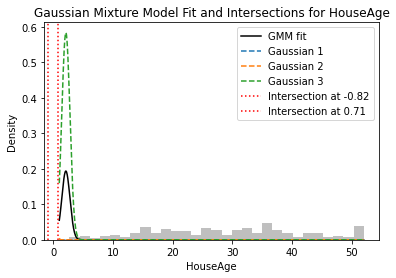

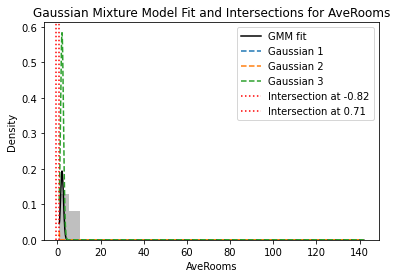

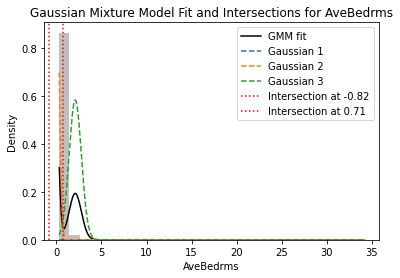

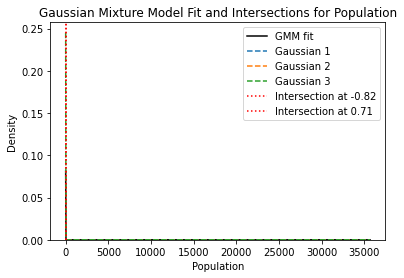

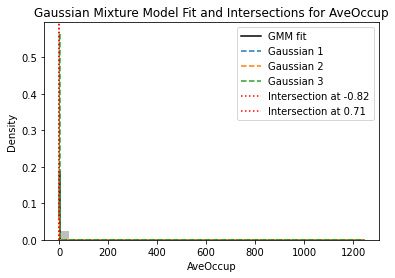

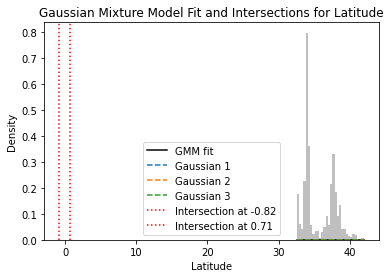

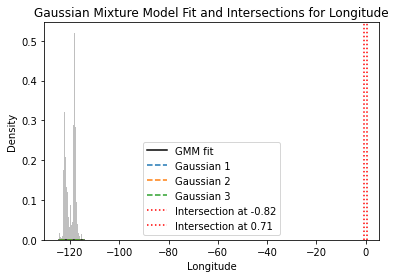

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_california_housing
import pandas as pd

# Load California Housing dataset
california = fetch_california_housing()
data = pd.DataFrame(california.data, columns=california.feature_names)

# Function to fit GMM and find intersections
def fit_gmm_and_find_intersections(data, n_components=3):
    # Fit a Gaussian Mixture Model
    def gmm_bic_score(estimator, X):
    # Make it negative since GridSearchCV expects a score to maximize
        return -estimator.bic(X)


    param_grid = {
        "n_components": range(0, 3),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
    grid_search = GridSearchCV(
        GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
    )
    grid_search.fit(data.reshape(-1, 1))
    
    # Extract the means and variances of the fitted Gaussians
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()
    std_devs = np.sqrt(variances)
    
    # Sort the means for determining intersections
    sorted_indices = np.argsort(means)
    sorted_means = means[sorted_indices]
    sorted_variances = variances[sorted_indices]
    
    # Determine the intersection points using the provided formula
    intersections = []
    for i in range(len(sorted_means) - 1):
        mu1, var1 = sorted_means[i], sorted_variances[i]
        mu2, var2 = sorted_means[i + 1], sorted_variances[i + 1]
        
        term1 = mu1*var2 - mu2*var1
        term2 = np.sqrt(var1*var2) * np.sqrt((mu1-mu2)**2 + (var2-var1)*np.log(var2/var1))
        term3 = var2-var1
        intersections.append(((term1 + term2) / term3))
    
    return gmm, sorted_means, sorted_variances, intersections

# Plotting function
def plot_feature(data, feature_name, n_components=3):
    feature_data = data[feature_name].values
    gmm, sorted_means, sorted_variances, intersections = fit_gmm_and_find_intersections(feature_data, n_components)
    
    x = np.linspace(min(feature_data), max(feature_data), 1000)
    pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    
    plt.hist(feature_data, bins=30, density=True, alpha=0.5, color='gray')
    plt.plot(x, pdf, label='GMM fit', color='black')
    
    for i in range(len(sorted_means)):
        plt.plot(x, (1 / np.sqrt(2 * np.pi * sorted_variances[i])) * 
                 np.exp(-(x - sorted_means[i])**2 / (2 * sorted_variances[i])),
                 label=f'Gaussian {i+1}', linestyle='--')
    
    for intersection in intersections:
        plt.axvline(intersection, color='red', linestyle=':', label=f'Intersection at {intersection:.2f}')
    
    plt.legend()
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.title(f'Gaussian Mixture Model Fit and Intersections for {feature_name}')
    plt.show()

# Plot for each feature in the dataset
for feature in data.columns:
    plot_feature(data, feature)


MedInc: 3


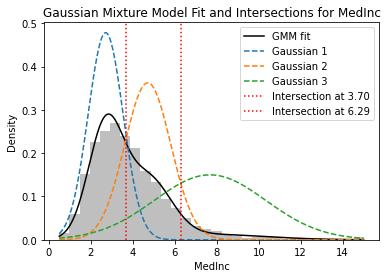

HouseAge: 3


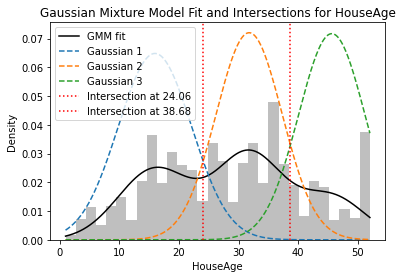

AveRooms: 3


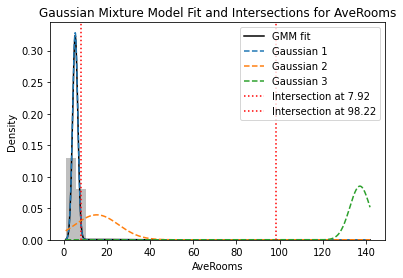

AveBedrms: 3


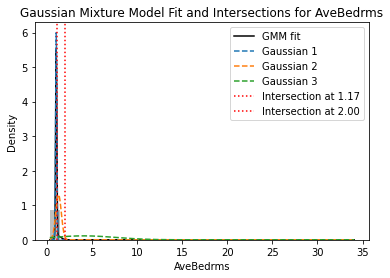

Population: 3


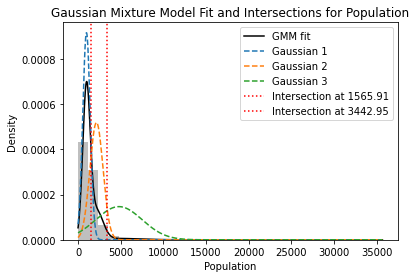

AveOccup: 1


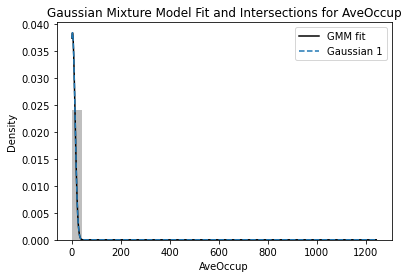

Latitude: 3


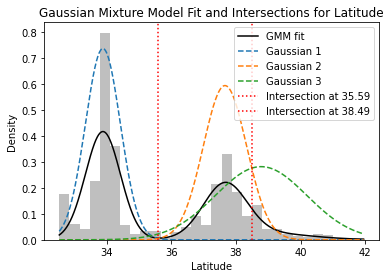

Longitude: 2


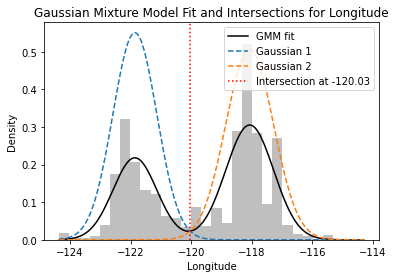

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Load California Housing dataset
california = fetch_california_housing()
data = pd.DataFrame(california.data, columns=california.feature_names)

# Function to fit GMM and find intersections
def fit_gmm_and_find_intersections(data, n_components=3):
    # Fit a Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data.reshape(-1, 1))
    
    # Extract the means and variances of the fitted Gaussians
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()
    std_devs = np.sqrt(variances)
    
    # Sort the means for determining intersections
    sorted_indices = np.argsort(means)
    sorted_means = means[sorted_indices]
    sorted_variances = variances[sorted_indices]
    
    # Determine the intersection points using the provided formula
    intersections = []
    for i in range(len(sorted_means) - 1):
        mu1, var1 = sorted_means[i], sorted_variances[i]
        mu2, var2 = sorted_means[i + 1], sorted_variances[i + 1]
        
        term1 = mu1*var2 - mu2*var1
        term2 = np.sqrt(var1*var2) * np.sqrt((mu1 - mu2)**2 + (var2 - var1) * np.log(var2 / var1))
        term3 = var2 - var1
        intersections.append(((term1 + term2) / term3))
    
    return gmm, sorted_means, sorted_variances, intersections

# Function to find the optimal number of components using GridSearchCV
def find_optimal_components(data):
    param_grid = {'n_components': [1, 2, 3]}
    gmm = GaussianMixture()
    grid_search = GridSearchCV(gmm, param_grid, cv=5)
    grid_search.fit(data.reshape(-1, 1))
    return grid_search.best_params_['n_components']

# Plotting function
def plot_feature(data, feature_name):
    feature_data = data[feature_name].values
    optimal_components = find_optimal_components(feature_data)
    print(f'{feature_name}: {optimal_components}')
    gmm, sorted_means, sorted_variances, intersections = fit_gmm_and_find_intersections(feature_data, optimal_components)
    
    x = np.linspace(min(feature_data), max(feature_data), 1000)
    pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    
    plt.hist(feature_data, bins=30, density=True, alpha=0.5, color='gray')
    plt.plot(x, pdf, label='GMM fit', color='black')
    
    for i in range(len(sorted_means)):
        plt.plot(x, (1 / np.sqrt(2 * np.pi * sorted_variances[i])) * 
                 np.exp(-(x - sorted_means[i])**2 / (2 * sorted_variances[i])),
                 label=f'Gaussian {i+1}', linestyle='--')
    
    for intersection in intersections:
        plt.axvline(intersection, color='red', linestyle=':', label=f'Intersection at {intersection:.2f}')
    
    plt.legend()
    plt.xlabel(feature_name)
    plt.ylabel('Density')
    plt.title(f'Gaussian Mixture Model Fit and Intersections for {feature_name}')
    plt.show()

# Plot for each feature in the dataset
for feature in data.columns:
    plot_feature(data, feature)
